In [1]:
import pandas as pd
train = pd.read_csv("train_titanic.csv")
test = pd.read_csv("test_titanic.csv")

In [2]:
test.shape

(418, 11)

In [3]:
train.shape

(891, 12)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

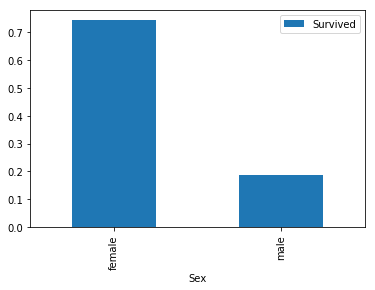

In [5]:
sex_pivot = train.pivot_table(index = "Sex", values = "Survived")
sex_pivot.plot.bar()

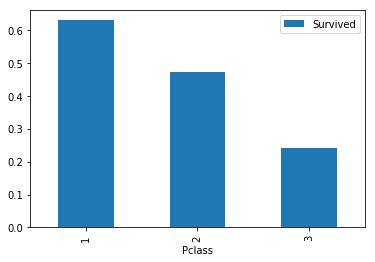

In [6]:
pclass_pivot = train.pivot_table(index = "Pclass", values = "Survived")
pclass_pivot.plot.bar()

In [7]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

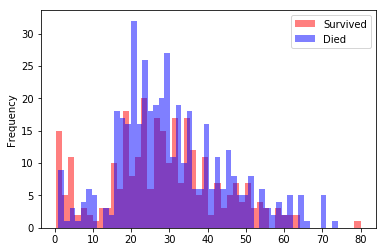

In [8]:
survived = train[train["Survived"] ==  1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=.5, color = 'red', bins= 50)
died["Age"].plot.hist(alpha = .5, color = 'blue', bins = 50)
plt.legend(['Survived','Died'])
plt.show()

as we see here there are breaks in the age variable but it isn't particularly easy to divide and break up into usable chunks. might be easier to break into discrete categorical parts to more easily work out the relationship between age and survival

we can use the cut method to divide the series into discrete chunks that we define

In [9]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

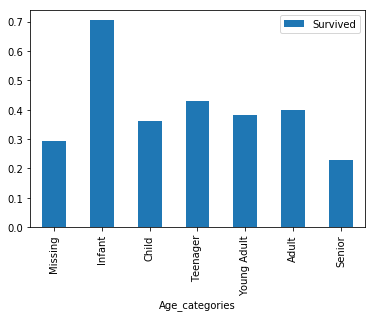

In [10]:
cut_points = [-1,0,5,12,18,35,60,100]
labels = ['Missing','Infant','Child','Teenager','Young Adult','Adult','Senior']
train = process_age(train, cut_points, labels)
test = process_age(test, cut_points, labels)

age_pivot = train.pivot_table(index = 'Age_categories', values = 'Survived')
age_pivot.plot.bar()

to ensure that the categorical variables are treated as such we can turn them into dummie columns each with a meaning of it being equal to teh label in that oclumn header

In [11]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train, "Sex")
test = create_dummies(test, "Sex")

train = create_dummies(train, "Age_categories")
test = create_dummies(test, "Age_categories")

since we are looking to predict a categorical variable Survived (0,1) we will use logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
columns = ['Pclass_1', 'Pclass_2','Pclass_3','Sex_female','Sex_male', 'Age_categories_Missing', 'Age_categories_Infant','Age_categories_Child'
          ,'Age_categories_Teenager','Age_categories_Young Adult','Age_categories_Adult','Age_categories_Senior']

In [13]:
lr.fit(train[columns], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

we should now evaluate our model using our train set. If we used all of our train set to evaluate we would be overfitting, so we must split our train set into a train and test inside that set

In [14]:
from sklearn.model_selection import train_test_split
all_X = train[columns]
all_Y = train['Survived']

train_X, test_X, train_Y, test_Y = train_test_split(all_X, all_Y, test_size = .2, random_state = 0)

In [15]:
lr.fit(train_X, train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
from sklearn.metrics import accuracy_score
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_Y, predictions)
accuracy

0.81005586592178769

to get an even better estimate on our model's performance we should use cross validation to go over all the different sections of our training data and estimate accuracy.

In [17]:
import numpy as np
from sklearn.model_selection import cross_val_score
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_Y, cv = 10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[ 0.8         0.81111111  0.7752809   0.87640449  0.80898876  0.78651685
  0.76404494  0.76404494  0.83146067  0.80681818]
0.802467086596


if we are happy with this accuracy value for our model we can now train a model on all our training data and predict our original test data

In [18]:
lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])
final_predictions = lr.predict(test[columns])

for a final Kaggle submission we should just submit the final_predictions in the form of PassengerID and Survived

In [19]:
final_ids = test['PassengerId']
final_df = {
    'PassengerId': final_ids,
    'Survived': final_predictions
}

submission = pd.DataFrame(final_df)
submission.to_csv("submission.csv", index = False)

now that we've built our first test if we were to submit this we see we get only around 72% correct. Which is a good place to start but we ahve a lot of potential for improvement

## Feature Engineering a new Model
Our original model was based on just three columns, the age, sex, and pclass of the passenger. There are a number of other columns we could potentially use to predict survival:

* SibSp - The number of siblings or spouses the passenger has on teh titanic
* Parch - the number of parents or children the passenger had on titanic
* ticket - the passengers ticket number
* Fare - price of their ticket
* Cabin - the cabin number of the passenger
* embarked - the port where the passenger embarked

At first glance it looks like name and ticket appear quite unique and could be generalized but are more difficult so we will pass on those for now. We can use the SibSp, Parch, and Fare columns as numerics, and Embarked appears to be a stnadard categorical column. We will process all these columns for potential use

In [20]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
test["Fare"] = test["Fare"].fillna(train["Fare"].mean())

train["Embarked"] = train["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

train = create_dummies(train, "Embarked")
test = create_dummies(test, "Embarked")

columns_to_scale = ["SibSp","Parch","Fare"]
for column in columns_to_scale:
    train[column + "_scaled"] = minmax_scale(train[column])
    test[column+"_scaled"] = minmax_scale(test[column])

C:\Users\chrisA\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


before throwing all these variables into the mix it'd be wise to measure which features are releant to our outcome- the survival of a passenger. An effective way is by training a logistic regression model using all the features then looking atthe coefficients of each. 

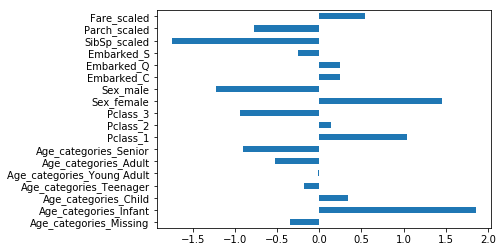

In [21]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']
lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=train[columns].columns)
feature_importance.plot.barh()
plt.show()

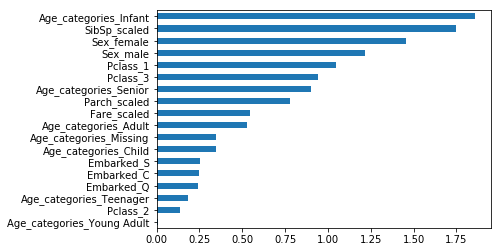

In [22]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()

let's create a model using just the top 8 values shown above

In [23]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train["Survived"], cv = 10)
accuracy = scores.mean()
print(accuracy)

0.814801952105


In [24]:
lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])
predictions = lr.predict(test[columns])
submission_dict = {
    "PassengerId" : test["PassengerId"],
    "Survived": predictions
}
submission_frame = pd.DataFrame(submission_dict)
submission_frame.to_csv("submission_1.csv", index = False)

if we were to upload this second attempt we woudl see that we're up to 77% correct answers. This is much better but we still haven't used a lot of the available data in our dataset so we could potentially do even better

we can use a process called binning like we did with age to create more variables that are more discrete and potentially mroe useful for the fare variable

In [25]:
def process_fare(df, cut_points, label_names):
    df["Fare_categories"] = pd.cut(df["Fare"], cut_points, labels = label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]
train = process_fare(train, cut_points, label_names)
test = process_fare(test, cut_points, label_names)

train = create_dummies(train, "Fare_categories")
test = create_dummies(test, "Fare_categories")

## Feature engineering from other categories

We can use the name columns to turn them into appropriate title groupings such as Mr, Mrs, Master, Miss, Officer, Royalty. 

In [26]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles_test = test["Name"].str.extract(' ([A-Za-z]+)\.',expand = False)
test["Title"] = extracted_titles_test.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")
test["Cabin_type"] = test["Cabin"].str[0]
test["Cabin_type"] = test["Cabin_type"].fillna("Unknown")

train = create_dummies(train, "Title")
test = create_dummies(test, "Title")
train = create_dummies(train, "Cabin_type")
test = create_dummies(test, "Cabin_type")

something we should be wary of at this point is collinearity since we have added so many new dimensions. collinearity occurs when more than one feature contains data that are similar. Collinearity will overfit a model. The model will perform quite well on test data but will perform worse on unseen data. 

For example, every person in our data set is categorized as male or female. So 'not_male' is the same as female. By having both dummies female and male is redundant because a 0 in the female column is a male and by having that male column we are just reiterating the data we already know from the female column.

A common way to check collinearity is to make a plot of the correlations between columns. If two columns are highly correlated then they are probably collinear. 



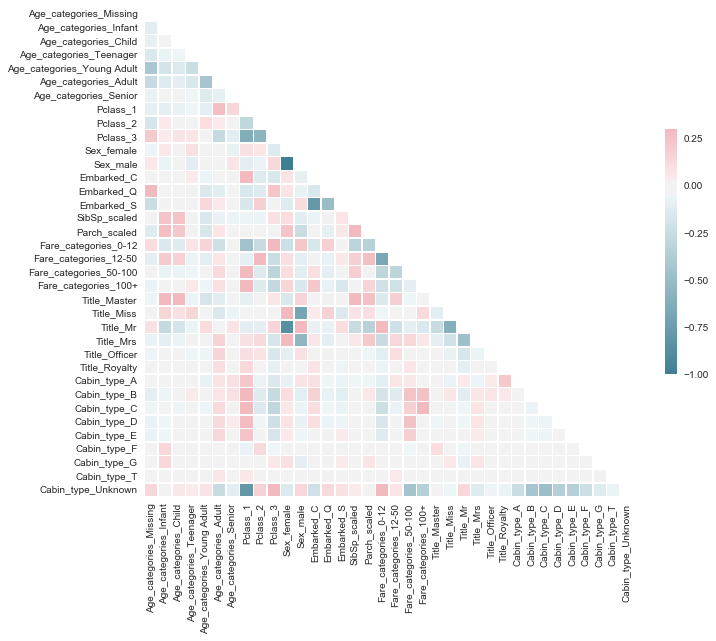

In [27]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

we notice a few obvious correlations. Being Male correlates negatively with the Female column i.e. a 0 in female is always a 1 in male and vice versa. 

We also see that a title Mr (exclusively male) correlates with being not female. 

This leads us to believe that the sex column information is intrinsic to the Title column information. So we may want to remove the sex columns as the title columns data is more nuanced and could bring more understanding than the sex columns

we should also remove one of each our dummy columns because if you arne't any of the others it is redundant to say you are the final option. 

we will remove 
* Pclass_2
* Age_categories_Teenager
* Fare_categories_12-50
* Title_Master
* Cabin_Type_A

there exists a class that uses cross validation to loop over each combination of variables to find the best scoring set of your features that you chosen to enter your model. This will return the proper feature set that scores the highest. 

This class is called RFECV or recursive feature elimination. It starts with all the features in the first model, then finds the least important feature and runs a new model and repeats this process until it has performed each successive model. Once complete it returns the list of features for the best performing model.

In [28]:
from sklearn.feature_selection import RFECV
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr,cv = 10)
selector.fit(all_X, all_y)

optimized_columns = all_X.columns[selector.support_]

from our initial 30+ features we have found that a model trained on just 4 features:
* SibSp_scaled
* Title_Mr
* Title_Officer
* Cabin_type_Uknown

performs  the best

In [29]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv= 10)
accuracy = scores.mean()

we see some improvement up to 82% accuracy with our new 4 feature model. we can try this on our test set and submit to kaggle to see what kind of score we can get

In [30]:
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(test[optimized_columns])
submission_dict = {
    'PassengerId': test['PassengerId'],
    'Survived':holdout_predictions
}

submission = pd.DataFrame(submission_dict)
submission.to_csv("submission_2.csv", index = False)

if we submit this model we jump up to roughly 78% accuracy on our test set. 

## Model Selection and Tuning

In [31]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Fare_categories',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title', 'Cabin_type',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown'],
      dtype='object')

In [32]:
train = train.drop(['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Age_categories','Title','Fare_categories', 'Cabin_type'], axis = 1)
test = test.drop(['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Age_categories','Title','Fare_categories', 'Cabin_type'], axis = 1)

In [33]:
all_X = train.drop(['Survived','PassengerId'], axis = 1)
all_y = train['Survived']

In [34]:
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy_lr = scores.mean()

In [35]:
accuracy_lr

0.82389144251503799

we can attempt to use k-nearest neighbors at this point to use a different algorith. 
k-nearest neighbors finds the observations in our training set most similar to the observation in our test set and uses the average outcome of those neighbor observations to make a prediction. the k comes from the number of neighbor observations used to make the prediction

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
scores = cross_val_score(knn, all_X, all_y, cv = 10)
accuracy_knn = scores.mean()

In [37]:
accuracy_knn

0.78461440245148117

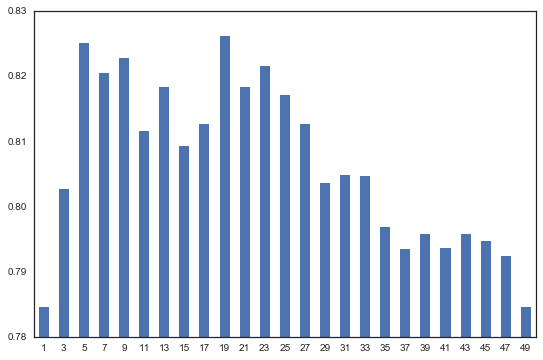

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()

for value in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors = value)
    scores = cross_val_score(knn, all_X, all_y, cv = 10)
    knn_scores[value] = scores.mean()
    
plot_dict(knn_scores)

looking at this plot we see that our optimal parameter for the number of neighbors is 19. 
this was a form of a grid search - we trained a number of models across a 'grid' of values and then serached for the model with the highest performance by accuracy. 

sci-kit has a class to perform these grid searches. model_selection.GridSearchCV() automates what we just did given we pass the hyperparameters we want to search over. 

In [39]:
knn = KNeighborsClassifier()
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(knn, param_grid = hyperparameters, cv = 10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)
best_params = grid.best_params_
best_score = grid.best_score_

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.828282828283


In [40]:
all_X.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown'],
      dtype='object')

In [41]:
# Get missing columns in the training test
missing_cols = set( train.columns ) - set( test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test = test[train.columns]

In [42]:
test_no_ids = test.drop(['PassengerId','Survived'], axis = 1)
best_knn = grid.best_estimator_
test_predictions = best_knn.predict(test_no_ids)
prediction_dict = {
    'PassengerId' : test['PassengerId'],
    'Survived': test_predictions
}

submission_df = pd.DataFrame(prediction_dict)
submission_df.to_csv("submission_knn.csv", index = False)

if we push that submission to kaggle we see that it scores slightly lower than our previously highest score, our logistic regression with 4 precision picked features. we will now try a random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 1)
scores = cross_val_score(clf, all_X, all_y, cv = 10)
accuracy_rf = scores.mean()

In [47]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

In [48]:
best_rf = grid.best_estimator_
test_predictions = best_rf.predict(test_no_ids)
prediction_dict = {
    'PassengerId' : test['PassengerId'],
    'Survived': test_predictions
}

submission_df = pd.DataFrame(prediction_dict)
submission_df.to_csv("submission_rf.csv", index = False)

this submission gets us to 77.1%. very close to our best submission from the logistic regression with 4 features